# Capstone Project 

**BrainStation Data Science Bootcamp - Machine Learning Project**

**Author: L Gavrilova**

**Date:  2023**

# Notebook 2b. Labelled Model Training

## 2.0 Imports

In [1]:
# Standard Libraries for data manipulation
import pandas as pd
import numpy as np
import re
import os
import string

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
plt.rcParams['figure.figsize'] = (6.0, 4.0) 
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('ggplot')

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt') # If needed

# Sentiment Analysis Libraries
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, mean_squared_error, r2_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# SMOTE for dealing with imbalanced datasets
from imblearn.over_sampling import SMOTE

# Additional Settings
import emoji

[nltk_data] Downloading package punkt to /Users/lgfolder/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
DATAFILE = '../data/labelled_dataset_wo_emoji.csv'
df = pd.read_csv(DATAFILE)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4996 entries, 0 to 4995
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   link_id     4996 non-null   object
 1   parent_id   4996 non-null   object
 2   User        4996 non-null   object
 3   Text        4996 non-null   object
 4   Intent      4996 non-null   object
 5   Support     4996 non-null   object
 6   emoji_text  742 non-null    object
dtypes: object(7)
memory usage: 273.3+ KB


In [4]:
df.describe()

,link_id,parent_id,User,Text,Intent,Support,emoji_text
count,4996,4996,4996,4996,4996,4996,742
unique,1944,3148,4659,4940,5,4,382
top,t3_ladzdt,t3_ladzdt,AutoModerator,GME,u,y,🚀 🚀 🚀
freq,66,46,14,22,3247,2473,66


In [5]:
df['Intent'].value_counts()

Intent
u    3247
y     983
m     370
i     313
n      83
Name: count, dtype: int64

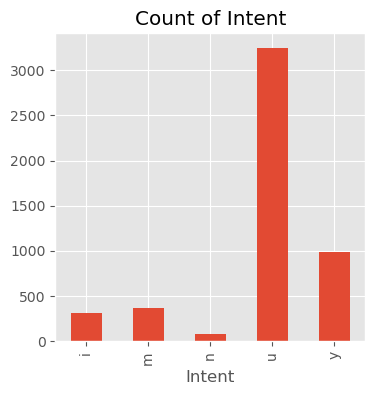

In [6]:
ax = df['Intent'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Intent',
          figsize=(4, 4))
ax.set_xlabel('Intent')
plt.show()

* Majority of posts (2/3) received clasification 'u', which means 'uncertain'. 
* 20% of posts were rated as "positive" signalling an intent to buy GME shares.
* Only a very small % of messages were rated as "negative" which creates an  imbalance in our set.  We have a deficit of examples of negative posts. 

## 2.1. Cleaning the text (pre-processing)

In [7]:
df.sample(5)

,link_id,parent_id,User,Text,Intent,Support,emoji_text
3636,t3_lnqdke,t1_go5ozs6,Aliienate,Sold 5c mar 19 SNDL at peak and cut my cost ba...,u,u,NaN
3995,t3_kbp0eu,t3_kbp0eu,wolfiasty,I'm locked with GME. Good luck to us both.,y,u,NaN
1974,t3_l69mob,t3_l69mob,bluerbnd,STFU YOU MORON. YOU COULDN'T SOUND MORE LIKE A...,u,y,🚀 🚀 🚀 🚀
1820,t3_l7kdww,t1_gl7812t,_HeyItsMyName_,Think of the bright side. I’m not an OG in any...,u,u,NaN
1977,t3_l8pegt,t1_gle4tf6,AdDecent8021,There will be no sell button for GME in my life,m,y,NaN


I am going to exclude information and unclear from the dataset. negative will be assugned rating 0, and positive will be assigned trating 1.  

In [8]:
# Two options together
#df['Intent'] = np.where((df['Intent'] == 'y')  | (df['Intent'] == 'm'), 1, 0)
#df['Support'] = np.where((df['Support'] == 'y') | (df['Intent'] == 'm'), 1, 0)

# Only one option
df['Intent'] = np.where((df['Intent'] == 'n'), 1, 0)
df['Support'] = np.where((df['Support'] == 'n'),1, 0)

df.head()

,link_id,parent_id,User,Text,Intent,Support,emoji_text
0,t3_l71j1l,t1_gl43z92,chasetate27,GME &amp; BB are not on cashapp but AMC &amp; ...,0,0,NaN
1,t3_ki3745,t3_ki3745,pmd5700,"Oh GME, you tease!",0,0,NaN
2,t3_la75n9,t3_la75n9,PigLizzard,"Dump gme, amc, nok, and bb so we can all buy s...",0,1,NaN
3,t3_lw6hoh,t1_gpfpvtf,anono87,Not a single decent double down posted? 9 bill...,0,0,NaN
4,t3_l9xqem,t3_l9xqem,gluino,Just got into $GME @ 220.,0,0,NaN


In [9]:
df['Intent'].value_counts()

Intent
0    4913
1      83
Name: count, dtype: int64

In [10]:
df['Support'].value_counts()

Support
0    4704
1     292
Name: count, dtype: int64

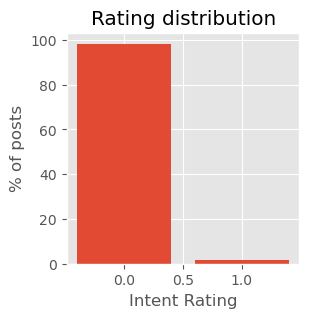

Class imbalance: [0.98 0.02]


In [11]:
values, counts = np.unique(df['Intent'], return_counts=True)
normalized_counts = counts / counts.sum()

plt.figure(figsize=(3, 3))
plt.bar(values, normalized_counts * 100)
plt.xlabel('Intent Rating')
plt.ylabel('% of posts')
plt.title("Rating distribution")
plt.show()


print(f"Class imbalance: {np.round(normalized_counts, 2)}")

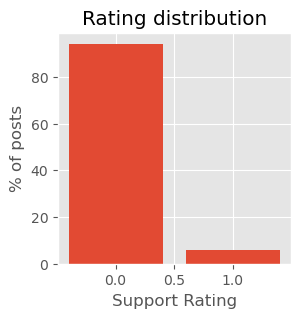

Class imbalance: [0.94 0.06]


In [12]:
values, counts = np.unique(df['Support'], return_counts=True)
normalized_counts = counts / counts.sum()

plt.figure(figsize=(3, 3))
plt.bar(values, normalized_counts * 100)
plt.xlabel('Support Rating')
plt.ylabel('% of posts')
plt.title("Rating distribution")
plt.show()
print(f"Class imbalance: {np.round(normalized_counts, 2)}")

### 2.1.1. Custom Tokenization function

In [13]:
#Load up our stop words from NLTK
stop_words = stopwords.words('english')

# Additional custom stopwords to add
custom_stopwords = ['gamestop', 'gme', 'game']

# Extend the NLTK stopwords list with custom stopwords
stop_words.extend(custom_stopwords)

In [14]:
# Defining my tokenisation function
def my_tokenizer(document, lemmatization=True, stemming=False):
    '''
    Function for use in Vectorizer that tokenizes the document.
    
    Parameters:
    - document: The text to be tokenized.
    - lemmatization: If True, perform lemmatization.
    - stemming: If True, perform stemming.
    
    Returns:
    - A list of tokens.
    '''
    
    # Replace newline characters with an empty string
    document = document.replace("\n", "")

    # Replace non-alphabetic characters with a space
    document = re.sub(r"[^a-zA-Z]", " ", document)

    # Replace multiple spaces with a single space
    document = re.sub(r"\s+", " ", document)

    # Strip leading and trailing spaces
    document = document.strip()

    # tokenize - split on whitespace
    tokenized_document = document.split(' ')

    # remove stopwords before stemming or lemmatization
    tokenized_document = [word for word in tokenized_document if word.lower() not in stop_words]

    # Perform stemming if set to True
    if stemming:
        stemmer = PorterStemmer()
        tokenized_document = [stemmer.stem(word) for word in tokenized_document]

    # Perform lemmatization if set to True
    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokenized_document = [lemmatizer.lemmatize(word) for word in tokenized_document]

    return tokenized_document


#EXTRA
#to modify the default parameters of my_tokenizer_pattern we can use a lambda function in-place:
#count_vectorizer = CountVectorizer(tokenizer=lambda document: my_tokenizer(document, lemmatization=True, stemming=False))

#what if we only wanted to extract letters, without numeric characters
#consider changing the pattern to pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b"

### Train test split

In [15]:
# store simplified data in X and y
X = df['Text']
y = df['Intent']

# splitting our data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)

# size of training data
X_train.shape

(3996,)

## 2.2. Vectorisation 

In [16]:
# Initialise a CountVectorizer object
count_vectorizer = CountVectorizer(tokenizer=my_tokenizer,
                                   stop_words=stop_words, # using stop words list that has been customised
                                   min_df=10, 
                                   ngram_range=(1,3), 
                                   max_features=1000)

# Preprocess the stop words with the custom tokenizer logic (if applicable)
processed_stop_words = set(my_tokenizer(' '.join(stop_words)))

# Fit the CountVectorizer object on X_train
count_vectorizer.fit(X_train)

# Fit the CountVectorizer object on X_train
X_matrix_train = count_vectorizer.transform(X_train)

print(X_matrix_train.shape);

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(3996, 1000)


In [17]:
# sum all the rows for each feature
word_counts = pd.DataFrame(
        {"counts": np.array(X_matrix_train.sum(axis=0)).flatten()},
        index=count_vectorizer.get_feature_names_out()).sort_values("counts", ascending=False)

print('The most common words and their counts are:')
word_counts[:20]

The most common words and their counts are:


,counts
optimistic,1727
super,1640
super optimistic,1628
optimistic super,1217
optimistic super optimistic,1217
super optimistic super,1205
buy,786
stock,727
investor,726
share,707


In [18]:
#toarray() method converts sparse matrix to a DataFrame
pd.DataFrame(X_matrix_train.toarray(),columns=count_vectorizer.get_feature_names_out()).head()

,able,absolutely,access,account,action,actual,actually,add,advice,advisor,...,wtf,x,ya,yeah,year,yes,yesterday,yet,yolo,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


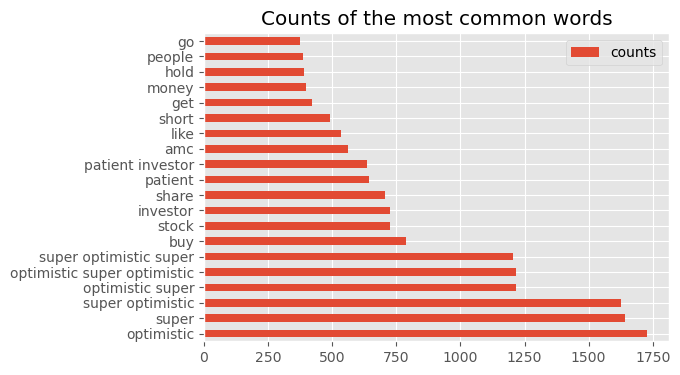

In [19]:
word_counts[:20].plot(kind='barh',title='Counts of the most common words')
plt.show()

Observations:  

* The list of words assocaited with neagtive reviews is quite revealing. 
* Customers clearly dislike unclean small rooms, tired decor, rude staff, poor breakfast selection, expensive hotels where quality does not match the price, broken amenities, noise and poor service.

### SMOTE sampling due to imbalance

In [20]:
# instantiate SMOTE sampler, fit it to the training data, then resample the data
X_train_sm, y_train_sm = SMOTE(random_state=1).fit_resample(X_matrix_train, y_train)

In [21]:
# check what SMOTE has done

print('Original class distribution')
display(pd.Series(y_train).value_counts().sort_index())

print('\nResampled class distribution')
display(pd.Series(y_train_sm).value_counts().sort_index())

Original class distribution


Intent
0    3930
1      66
Name: count, dtype: int64


Resampled class distribution


Intent
0    3930
1    3930
Name: count, dtype: int64

In [22]:
# scale the sampled train data and the unsampled test data
#ss_sm = StandardScaler().fit(X_train_sm)
#X_train_sm_ss = ss_sm.transform(X_train_sm)
#X_test_ss = ss_sm.transform(X_test)

## 2.3. Simple Logistic Regression

Now that we are happy with the number of features, let's fit a classification model and preprocess the test set

In [23]:
X_matrix_test = count_vectorizer.transform(X_test)
X_matrix_test.shape

(1000, 1000)

In [24]:
logistic_model=LogisticRegression(solver='liblinear', max_iter=1000) # Using liblinear solver - good for small datasets
logistic_model.fit(X_matrix_train,y_train)
print(f"Train set accuracy {logistic_model.score(X_matrix_train,y_train):.2f}")
print(f"Test set accuracy {logistic_model.score(X_matrix_test,y_test):.2f}")

# Make predictions on the test set
test_predictions = logistic_model.predict(X_matrix_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, test_predictions))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

Train set accuracy 0.99
Test set accuracy 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       983
           1       0.33      0.06      0.10        17

    accuracy                           0.98      1000
   macro avg       0.66      0.53      0.55      1000
weighted avg       0.97      0.98      0.98      1000

Confusion Matrix:
[[981   2]
 [ 16   1]]


* Note, train scores can also be used as one of the metrics to select the optimal min_df & max_df parameters
* Now we can use the model object to access and specifically its **coef_** amd **feature_names_in_** attributes to plot which tokens have the greatest predictive power of negative and postiive reviews
    * Note this approach is only going to work if the model was fitted on a dataframe with the correct feature names, if an array was used, feature names can be extracted from the vectorizer used previously

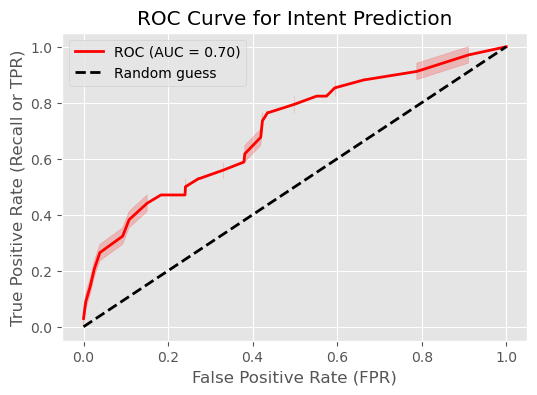

In [25]:
# probabilistic prediction
y_test_proba = logistic_model.predict_proba(X_matrix_test)[:,1] # probabilities of data points being in the positive class

# ROC arrays
fprs, tprs, thresholds = roc_curve(y_test, y_test_proba)

# AUC
roc_auc = roc_auc_score(y_test, y_test_proba)

# plot
plt.figure()
sns.lineplot(x=fprs, y=tprs, color='red', lw=2, label=f'ROC (AUC = {roc_auc:0.2f})')  # Corrected line
sns.lineplot(x=[0, 1], y=[0, 1], color='black', lw=2, linestyle='--', label='Random guess')  # Corrected line and added linestyle for clarity

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall or TPR)')
plt.title('ROC Curve for Intent Prediction')
plt.legend(loc='best')
plt.show()

Remember what the threshold is - if the probabilistic prediction of a data point being in the positive class is at or greater than x threshold, then our hard classifier will assign that data point to the positive class.  e.g. if our threshold is 0.3, and the probability of a data point being in the positive class is 0.4, then the hard classification is that the data point is positive.

Remember what the ROC curve represents - "if I were to set my threshold at x, then our model would have a TPR of y, but we would have to live with an FPR of z".
- **A threshold of 0 is the point at the top right of the ROC curve** - we are intentionally classifying every data point as positive, thus we correctly classify all the true positive data points ($TPR = 100\%$) but fail to correctly classify any of the true negative data points ($FPR = 100\%$)
- **A threshold of 1 is the point at the bottom left of the curve** - we are intentionally classifying every data point as negative, thus we correctly classify all the true negative data points ($FPR = 0\%$) but fail to correctly classify any of the true positive data points ($TPR = 0\%$)

Train set accuracy after SMOTE 0.94
Test set accuracy after SMOTE 0.86
Classification Report after SMOTE:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       983
           1       0.02      0.18      0.04        17

    accuracy                           0.86      1000
   macro avg       0.50      0.52      0.48      1000
weighted avg       0.97      0.86      0.91      1000

Confusion Matrix after SMOTE:
[[855 128]
 [ 14   3]]


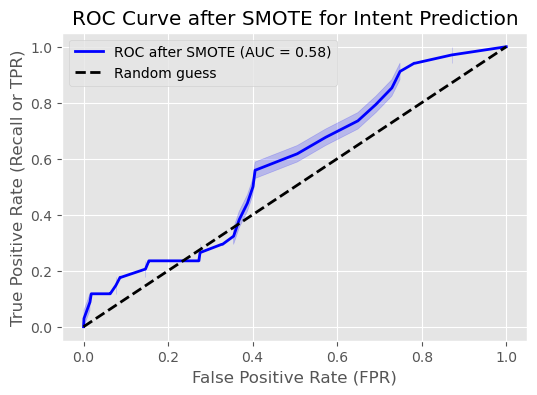

In [26]:
# Logreg with SMOTE

# Initialize the logistic regression model
logistic_model_sm = LogisticRegression(solver='liblinear', max_iter=1000)

# Fit the model on the SMOTE resampled training data
logistic_model_sm.fit(X_train_sm, y_train_sm)

# Evaluate the model on the original training set
print(f"Train set accuracy after SMOTE {logistic_model_sm.score(X_train_sm, y_train_sm):.2f}")

# Evaluate the model on the test set
print(f"Test set accuracy after SMOTE {logistic_model_sm.score(X_matrix_test, y_test):.2f}")

# Make predictions on the test set using the model trained on SMOTE data
test_predictions_sm = logistic_model_sm.predict(X_matrix_test)

# Print classification report
print("Classification Report after SMOTE:")
print(classification_report(y_test, test_predictions_sm))

# Print confusion matrix
print("Confusion Matrix after SMOTE:")
print(confusion_matrix(y_test, test_predictions_sm))

# Get probabilistic predictions
y_test_proba_sm = logistic_model_sm.predict_proba(X_matrix_test)[:,1]

# ROC arrays
fprs_sm, tprs_sm, thresholds_sm = roc_curve(y_test, y_test_proba_sm)

# AUC
roc_auc_sm = roc_auc_score(y_test, y_test_proba_sm)

# Plot
plt.figure()
sns.lineplot(x=fprs_sm, y=tprs_sm, color='blue', lw=2, label=f'ROC after SMOTE (AUC = {roc_auc_sm:0.2f})')
sns.lineplot(x=[0, 1], y=[0, 1], color='black', lw=2, linestyle='--', label='Random guess')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall or TPR)')
plt.title('ROC Curve after SMOTE for Intent Prediction')
plt.legend(loc='best')
plt.show()

*---------------------------------------------------------------------*
### Model Analysis

/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_87270/2985225999.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(coef_df.tail(20)["token"], rotation=45)
/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_87270/2985225999.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(coef_df.head(20)["token"], rotation=45)


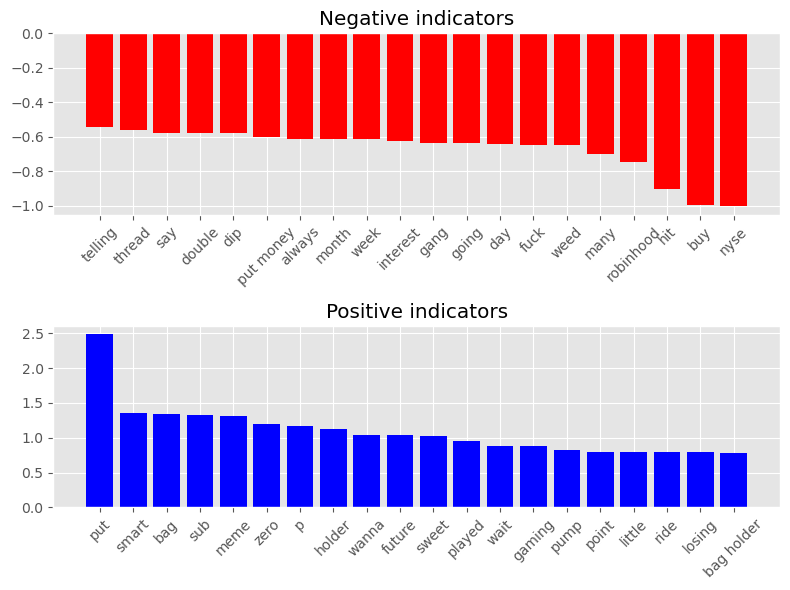

In [27]:
def plot_coefs(model):
    # Create a DataFrame to store the coefficients and corresponding tokens
    coef_df = pd.DataFrame({"coefficient": model.coef_[0], "token": count_vectorizer.get_feature_names_out()})
    # Sort by coefficients
    coef_df = coef_df.sort_values("coefficient", ascending=False)

    # Create a figure with 2 subplots
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))

    # Plot tokens indicating negative sentiment with smallest coefficients
    axs[0].bar(coef_df.tail(20)["token"], coef_df.tail(20)["coefficient"], color="red")
    axs[0].set_xticklabels(coef_df.tail(20)["token"], rotation=45)
    axs[0].set_title("Negative indicators")

    # Plot tokens indicating positive sentiment with largest coefficients
    axs[1].bar(coef_df.head(20)["token"], coef_df.head(20)["coefficient"], color="blue")
    axs[1].set_xticklabels(coef_df.head(20)["token"], rotation=45)
    axs[1].set_title("Positive indicators")

    fig.tight_layout()
    plt.show()

plot_coefs(logistic_model)

Observation:  

The model accuracy on test set is close to the accuracy on the train and valildation sets. This is a good sign, as it inidcates there is no problem with overfitting the model.  We have sufficient number of observations to train the model so that when it is faced with unseen test data it still performs well.   

## 2.X. Gridsearch for logreg

In [28]:
# Pipeline composition, includes preprocessing and the classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Vectorization
    ('svd', TruncatedSVD(n_components=100)),  # Dimensionality reduction for sparse data, using SVD instead of PCA for sparse data
    ('logr', LogisticRegression(solver='liblinear'))  # Classifier with  liblinear solver - good for small datasets
])

# Define the hyperparameters space to search
param_grid = {
    'tfidf__max_df': [0.8, 0.85, 0.9], # this parameter allows to ignore words that appear in more than XX% of the documents. 
    'tfidf__ngram_range': [(1, 2), (1, 3)], # both unigrams and bigrams will be used as features
    'svd__n_components': [200, 250, 300], # reduce the feature space to the top 100 components
    'logr__C': [10, 100, 200]
}

# Set up GridSearchCV to search for the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# X_train on the raw text data
grid_search.fit(X_train, y_train)

# After fitting, get the best estimator
best_model = grid_search.best_estimator_

# Predict the test set using the best model
test_predictions = best_model.predict(X_test)


In [29]:
# Calculate the accuracy
test_accuracy = accuracy_score(y_test, test_predictions)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, test_predictions))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

Best hyperparameters: {'logr__C': 200, 'svd__n_components': 200, 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 3)}
Test Accuracy: 0.9850
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       983
           1       1.00      0.12      0.21        17

    accuracy                           0.98      1000
   macro avg       0.99      0.56      0.60      1000
weighted avg       0.99      0.98      0.98      1000

Confusion Matrix:
[[983   0]
 [ 15   2]]


In [30]:
# Importing the best parameters into the pipeline for further export to other notebooks

# Extract the best parameters
best_params = grid_search.best_params_

# Create a new pipeline with the best parameters
best_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=best_params['tfidf__max_df'],
                              ngram_range=best_params['tfidf__ngram_range'])),
    ('svd', TruncatedSVD(n_components=best_params['svd__n_components'])),
    ('logr', LogisticRegression(C=best_params['logr__C'], solver='liblinear'))
])

# Fit the best pipeline on the full training set
best_pipeline.fit(X_train, y_train)

# Now you can use best_pipeline to predict, like so:
test_predictions = best_pipeline.predict(X_test)

In [31]:
# Save the best model using joblib
# joblib.dump(best_model, "../model/labeled_yes_best_linear_grid_search_model.pkl")
# print("Best model saved to '../model/labeled_yes_best_linear_grid_search_model.pkl'")

In [32]:
# Save the best pipline using joblib
from joblib import dump
dump(best_model, '../model/labelled_yes_linear_pipeline.pkl', compress=True)

['../model/labelled_yes_linear_pipeline.pkl']

## 2.5. Decision Tree Classifier

### 2.5.1. Set up a pipeline

In [33]:
# PCA does not support sparse input, converting sparce matrix into a dense matrix
X_matrix_train_dense = X_matrix_train.toarray()
X_matrix_test_dense = X_matrix_test.toarray()

In [34]:
# Create a pipeline with PCA and a decision tree classifier
pipeline = Pipeline([
    ('pca', PCA(n_components=20)),
    ('clf', DecisionTreeClassifier())
])

In [35]:
# Define the hyperparameters
param_grid = {
    'clf__max_depth': [1,2, 3, 5, 7, 10, 15,20], 
    'clf__min_samples_split': [2,3,4,5,6,7,8], 
    'clf__min_samples_leaf': [2,4,5,6,7,8]  
}

### 2.5.2. Hyperparameter optimization

* I use GridSearchCV to search over a specified parameter grid. 
* I tried to set up Gridsearch to do the pre-processing (Vectorisation) but I could not figure out how to do it. 
* GridSearchCV will use cross-validation internally, so no need to set up a separate validation set.  

In [36]:
# Set up GridSearchCV 
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

In [37]:
grid_search.fit(X_matrix_train_dense, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA(n_components=20)),
                                       ('clf', DecisionTreeClassifier())]),
             param_grid={'clf__max_depth': [1, 2, 3, 5, 7, 10, 15, 20],
                         'clf__min_samples_leaf': [2, 4, 5, 6, 7, 8],
                         'clf__min_samples_split': [2, 3, 4, 5, 6, 7, 8]})

In [38]:
# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'clf__max_depth': 1, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}


### 2.5.3. Parameters to optimize.

In [39]:
best_model = grid_search.best_estimator_

# Using the dense version of X_test, which is X_matrix_test_dense
test_preds = best_model.predict(X_matrix_test_dense)

# Accuracy using the true labels y_test and the predicted labels test_preds
val_acc = accuracy_score(y_test, test_preds)
print(f"Validation Accuracy with Best Parameters: {val_acc:.4f}")

Validation Accuracy with Best Parameters: 0.9830


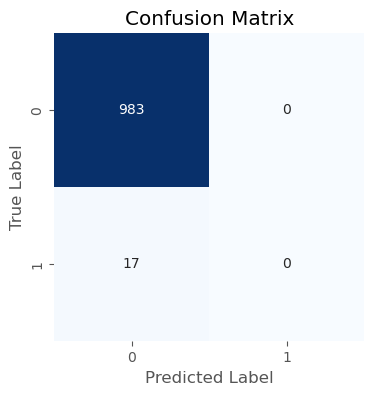

In [40]:
matrix = confusion_matrix(y_test, test_preds)

# Displaying the confusion matrix 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [41]:
# Printing the classification report
report = classification_report(y_test, test_preds)
print(report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       983
           1       0.00      0.00      0.00        17

    accuracy                           0.98      1000
   macro avg       0.49      0.50      0.50      1000
weighted avg       0.97      0.98      0.97      1000



/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Observation:  

* The DT classifier combined with the gridsearch for best hyperparameters combination have not resulted in  a better model than the logistical regression constratucted earlier.  The accuracy score of 74% is lower than 78% for the logreg model.  BUt 74% is still better than the 57% for the majority class os 1s. 
* The DT model has a slightly better performance in classifying positive reviews (1s) with a precision of 0.76 and recall of 0.80, compared to classifying negative reviews (0s) which has a precision of 0.72 and recall of 0.67. 
* Overall, with an accuracy is 0.74. The model classifies well between positive and negative reviews, although there's a margin for improvement.

## 2.x. VADER Sentiment Analyser

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4996 entries, 0 to 4995
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   link_id     4996 non-null   object
 1   parent_id   4996 non-null   object
 2   User        4996 non-null   object
 3   Text        4996 non-null   object
 4   Intent      4996 non-null   int64 
 5   Support     4996 non-null   int64 
 6   emoji_text  742 non-null    object
dtypes: int64(2), object(5)
memory usage: 273.3+ KB


In [43]:
# Instantiate an object of SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [44]:
# This code checks the content of each inidividual text cell and prints the post text and the sentiment ratings below:

i = 2011

print(df["User"].loc[i])
print(df["Text"].loc[i])
print(df["Intent"].loc[i])
print(df["Support"].loc[i])
post = df["Text"].loc[i]

# Calculates the sentiment scores for the chosen cell
overall_sentiment_score = analyzer.polarity_scores(post)
print(overall_sentiment_score)

Mooseknuckle94
Keep them patient investors up boys! AMC/GME . (Cut that "buy at xxx time" shit out too ya jackasses)
0
0
{'neg': 0.38, 'neu': 0.62, 'pos': 0.0, 'compound': -0.8687}


In Vader documentation (https://github.com/cjhutto/vaderSentiment#about-the-scoring) it is explained that if:

"
    The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

    It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

* positive sentiment: compound score >= 0.5
* neutral sentiment: (compound score > -0.5) and (compound score < 0.5)
* negative sentiment: compound score <= -0.5.

    NOTE: The compound score is the one most commonly used for sentiment analysis by most researchers, including the authors.

    The pos, neu, and neg scores are ratios for proportions of text that fall in each category (so these should all add up to be 1... or close to it with float operation)."

In [45]:
# Define a function that will go through posts and assign sentimen scores to text:
def calculate_sentiment(text):
    if pd.isnull(text):
        return {'neg': None, 'neu': None, 'pos': None, 'compound': None}
    
    # Analyze the sentiment of the post
    sentiment_score = analyzer.polarity_scores(text)
    return sentiment_score

In [46]:
# Apply the calculate_sentiment function to each row in the 'title' column (runtime = 2 seconds)
sentiments = df['Text'].apply(calculate_sentiment)

# Record the sentiments into the dataframe new columns (v= vader)
df.loc[:, 'neg_v'] = sentiments.apply(lambda x: x['neg'])
df.loc[:, 'neu_v'] = sentiments.apply(lambda x: x['neu'])
df.loc[:, 'pos_v'] = sentiments.apply(lambda x: x['pos'])
df.loc[:, 'compound_v'] = sentiments.apply(lambda x: x['compound'])

In [47]:
# Bin the compound scores into categories
df['compound_v_binned'] = pd.cut(df['compound_v'], bins=[-1, -0.5, 0, 0.5, 1], labels=['Very Negative', 'Negative', 'Positive', 'Very Positive'])

# Crosstab between binned compound score and Intent
crosstab_v_intent_binned = pd.crosstab(df['compound_v_binned'], df['Intent'], rownames=['compound_v'], colnames=['Intent'])
print("\nCrosstab between binned Vader compound score and Intent:\n", crosstab_v_intent_binned)


Crosstab between binned Vader compound score and Intent:
 Intent            0   1
compound_v             
Very Negative   628  12
Negative       1839  27
Positive       1034  23
Very Positive  1412  21


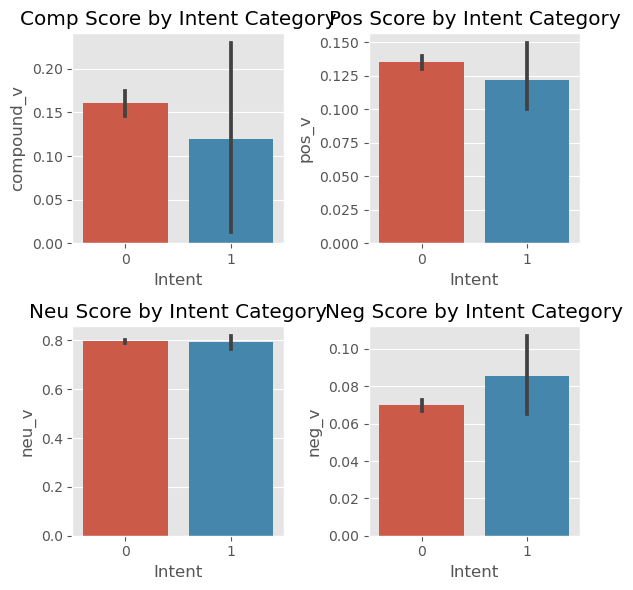

In [48]:
# Plotting graphs to show the distribution of Vader ratings
fig, axes = plt.subplots(2, 2, figsize=(6, 6))  # Adjust the size as needed


sns.barplot(ax=axes[0, 0], data=df, x='Intent', y='compound_v')
axes[0, 0].set_title('Comp Score by Intent Category')

sns.barplot(ax=axes[0, 1], data=df, x='Intent', y='pos_v')
axes[0, 1].set_title('Pos Score by Intent Category')

sns.barplot(ax=axes[1, 0], data=df, x='Intent', y='neu_v')
axes[1, 0].set_title('Neu Score by Intent Category')

sns.barplot(ax=axes[1, 1], data=df, x='Intent', y='neg_v')
axes[1, 1].set_title('Neg Score by Intent Category')

plt.tight_layout()
plt.show()

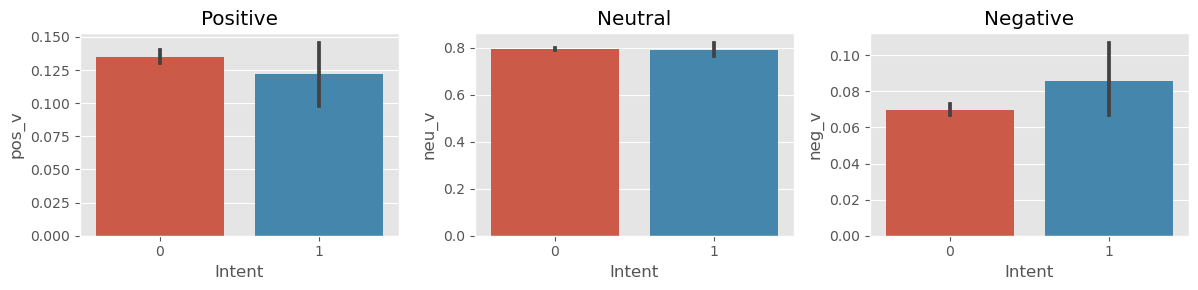

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=df, x='Intent', y='pos_v', ax=axs[0])
sns.barplot(data=df, x='Intent', y='neu_v', ax=axs[1])
sns.barplot(data=df, x='Intent', y='neg_v', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

I can see on the distribution graphs above that Vader sentiment alone is not sufficient to classify WSB messages correctly. Vader has been trained on general language models, and does not capture the financial sentiment and context well. 

I dont think this Vader sentiment analyser works at all, as messages scored 1 on Intent to buy were somewhat evenly split between negative and positive sentiments. Negative sentiment is more predictive that the message will be a zero (a higher % of very negative messages are assigned a rating of 0), but this is very imprecise.  

The correlation coefficient calcualted below indicate very low correlation between Intent and VADER scores:

In [50]:
# Features matrix (X) and target vector (y)
X = df[['neg_v','pos_v','neu_v','compound_v']] 
y = df['Intent'] 

# Calculating the correlation of X an y
correlation = X.corrwith(y)
print(correlation)

neg_v         0.02
pos_v        -0.01
neu_v        -0.00
compound_v   -0.01
dtype: float64


Just to be sure, below I built a linear regression to check if I can spot any relationships here:

In [51]:
# Building linear regression between Intent and the Vader sentiment

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler using only the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and fit the linear regression model to the scaled data
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = model.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing out the coefficients and the metrics
print(f"Coefficients: \n{model.coef_}")
print(f"Intercept: {model.intercept_}")
print(f"Mean squared error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")


Coefficients: 
[-1.49795723e+00 -2.42665928e+00 -2.62586610e+00  1.64640014e-05]
Intercept: 0.014514514514515577
Mean squared error (MSE): 0.0245
R-squared (R2): -0.0056


Concludion:  we have a negative R-squared, which means that the VADER sentiment analyser is not helpful at all in classifying our data, even assigning ratings in the opposite direction of what we could expect. VADER tool can be helpful, perhaps, if it is assisted with "translation" of unique WSB jargon language into a normal english that VADER has been trained to understand.  

## 2.z. TextBlob from NLTK

In [52]:
from textblob import TextBlob

* In TextBlob NLTM Library sentiment is captured by polarity score, ranging from negative (-1) to positive (+1). 
* Subjectivity is graded from 0 to 1, with 0 being very factual/objecive and 1 being very subjective. 
* As a reminder, our Intent field is not very balanced, with only 23% of ratings having positive intent to buy.

In [53]:
# This code checks the content of each inidividual text cell 
i = 106

print(df["User"].loc[i])
print(df["Text"].loc[i])
print(df["Intent"].loc[i])
print(df["Support"].loc[i])

post = df["Text"].loc[i]

# VADER (from above)
overall_sentiment_score = analyzer.polarity_scores(post)
print("VADER sentiment score:")
print(overall_sentiment_score)

# TextBlob 

analysis = TextBlob(post)
print("TextBlob sentiment score:")
print(analysis.sentiment)

Lil_Orphan_Anakin
To be fair I didn’t want to sound retarded when I was convincing her to buy so I think I told her “some people think it might hit $30 pretty soon.” I guess she interpreted that as $30 being the ceiling. I should’ve done the smart thing and sent her GME $420.69 memes so she would hold longer
0
0
VADER sentiment score:
{'neg': 0.054, 'neu': 0.766, 'pos': 0.18, 'compound': 0.7579}
TextBlob sentiment score:
Sentiment(polarity=0.21071428571428572, subjectivity=0.7904761904761904)


In the code above I can flip through various posts by comparing the content and the sentiment rating assigned by VADER and TextBlob

In [54]:
# Reminding myself what is the class composition in our "Intent" column
df['Intent'].value_counts()
values, counts = np.unique(df['Intent'], return_counts=True)
normalized_counts = counts / counts.sum()
print(f"Class imbalance: {np.round(normalized_counts, 2)}")

Class imbalance: [0.98 0.02]


In the code below I calculate the totals of positive and negative posts.  If polarity rating is >0, then I count it as a positive score, and if polarity is less than 0, then I count it as a negative sentiment.  I can compare the totals of the dataset to my distribution of categoris for 'Intent'.  With threshhold set at zero I have too many positive ratings, so I needed to change the threshhold to dial down positivity of the dataset. I now classify polarity scores as positive only once they reach a certain threshhold, for example they need ot be above 0.2 to be counted as positive. By experimenting a bit, I determined that threashhold of 0.2 is a good threshhold to get to the desired distribution of 1 and 0 (hopefully matching the distribution of labels).  I am recording this calculated sentiment score into my model. 

In [55]:
# this code borrowed from TextBlob sentiment analysis tutorial at https://pythonprogramming.net/sentiment-analysis-python-textblob-vader/

pos_count = 0
pos_correct = 0

# 'Text' column to be analyzed with TextBlob
for line in df['Text']:
    analysis = TextBlob(line)
    if analysis.sentiment.polarity > .00:
        pos_correct += 1
    pos_count += 1

neg_count = 0
neg_correct = 0

for line in df['Text']:
    analysis = TextBlob(line)
    if analysis.sentiment.polarity <= 0.0:
        neg_correct += 1
    neg_count += 1

print("Positive sentiment = {:.2f}% via {} samples".format(pos_correct/pos_count*100.0, pos_count))
print("Negative sentiment = {:.2f}% via {} samples".format(neg_correct/neg_count*100.0, neg_count))


Positive sentiment = 45.06% via 4996 samples
Negative sentiment = 54.94% via 4996 samples


In [56]:
# Define a function to apply TextBlob analysis and create new columns
def apply_textblob(sentiment_text):
    analysis = TextBlob(sentiment_text)
    subj_score = analysis.sentiment.subjectivity
    pol_score = analysis.sentiment.polarity
    sentim_score = 1 if pol_score > 0.2 else 0
    return subj_score, pol_score, sentim_score

# Apply the function and assign new columns
df[['subj_tb1', 'pol_tb1', 'sentim_tb1']] = df.apply(lambda row: apply_textblob(row['Text']), axis=1, result_type='expand')

Observation:

* the R squared is extremely low.  There is nearly no correlation between the TextBlob assigned sentiment metrics, such as polarity and subjectivity and the labels assigned by researchers. 

In [57]:
# Crosstab between sentim_tb1 and Intent
crosstab_tb1_intent = pd.crosstab(df['sentim_tb1'], df['Intent'], rownames=['sentim_tb1'], colnames=['Intent'])
print("\nCrosstab between sentim_tb1 and Intent:\n", crosstab_tb1_intent)


Crosstab between sentim_tb1 and Intent:
 Intent         0   1
sentim_tb1          
0.00        3780  60
1.00        1133  23


In [58]:
# Features matrix (X) and target vector (y)
X = df[['subj_tb1', 'pol_tb1']]  # Using both columns as features
y = df['Intent']                 # Target variable

# Calculating the correlation of X an y
correlation = X.corrwith(y)
print(correlation)

subj_tb1   0.02
pol_tb1    0.02
dtype: float64


In [59]:
# Building linear regression between Intent and the TextBlob sentiment

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler using only the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and fit the linear regression model to the scaled data
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = model.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing out the coefficients and the metrics
print(f"Coefficients: \n{model.coef_}")
print(f"Intercept: {model.intercept_}")
print(f"Mean squared error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")


Coefficients: 
[0.00192357 0.00289079]
Intercept: 0.014514514514514515
Mean squared error (MSE): 0.0245
R-squared (R2): -0.0051


I will try the logistics regression below

In [60]:
# Building a logistic regression on the TextBlob sentiment analysis accuracy

# Features matrix (X) and target vector (y)
X = df[['sentim_tb1']]  # Features need to be in a 2D array for sklearn
y = df['Intent']        # Target is just a series

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Generating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Printing out the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.9750
Recall: 0.0000
Precision: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[975   0]
 [ 25   0]]


/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Conlcusion on TextBlob:

* It is challenging to predict sentiment score on Reddit posts intent to buy based on the NLTK TextBlob sentiment analyser. 
* I tried several different settings/combinations on the threshhold (for positivity and subjectivity).  Unfortunately, none of them yielded good results.  
* TextBlob sentiment encoder shows very poor results on WSB dataset when applied without additional language adjustments. I should try to change the language using my own dictionary of WSB specific terms   

Need to do NN